# Hilfsfunktion, um IoU zu berechnen

iou=0.00


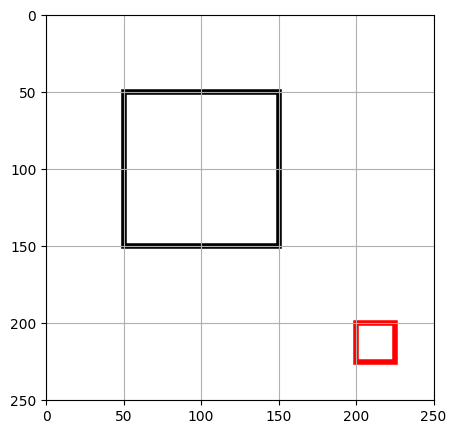

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_iou(box1, box2, visualize=False):

    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # "Intersection Rectangle" berechnen
    i_min_x = max(x1_min, x2_min)
    i_min_y = max(y1_min, y2_min)
    i_max_x = min(x1_max, x2_max)
    i_max_y = min(y1_max, y2_max)

    # Seitenlänge des Intersec. Rect. berechnen
    i_width  = max(0, i_max_x - i_min_x)
    i_height = max(0, i_max_y - i_min_y)

    # Fläche des Intersec. Rect. ausrechnen
    i_area = i_width * i_height

    # Fläche der beiden BBoxen ausrechnen
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Fläche der Vereinigung ("Union") ausrechnen
    union_area = box1_area + box2_area - i_area

    # Rechne IoU aus
    iou = i_area / union_area

    if visualize:
        f = plt.figure(figsize=(5,5))
        ax = f.add_subplot(111)

        N = 250
        ax.set_xlim(0,N)
        ax.set_ylim(0,N)

        # Zeichnen box1
        ax.add_patch( patches.Rectangle((x1_min,y1_min),
                                         x1_max - x1_min,
                                         y1_max - y1_min,
                                         fill=False,
                                         color="black",
                                         lw=4
                                       ))

        # Zeichnen box2
        ax.add_patch( patches.Rectangle((x2_min,y2_min),
                                         x2_max - x2_min,
                                         y2_max - y2_min,
                                         fill=False,
                                         color="red",
                                         lw=4
                                       ))

        if i_area > 0:

            # Zeichne Intersect. Rectangle
            ax.add_patch( patches.Rectangle((i_min_x, i_min_y),
                                         i_width,
                                         i_height,
                                         fill=True,
                                         color="yellow",
                                         lw=1
                                       ))
        
        ax.invert_yaxis()
        ax.grid()

    return iou

box1 = [50,50,150,150]
box2 = [200,200,225,225]
#box2 = [75,75,200,200]
iou = calculate_iou(box1, box2, visualize=True)
print(f"iou={iou:.2f}")

# Ground-Truth Boundingboxen parsen

In [2]:
def get_gt_bboxes(img_fname):
    # 1. Bestimme Name der Annotationsdatei
    annotation_fname = img_fname.replace("/PNGImages/", "/Annotation/")
    annotation_fname = annotation_fname[:-4] + ".txt"
    #print(annotation_fname)

    # 2. Annotationsdatei einlesen
    datei = open(annotation_fname, "r")
    lines = datei.readlines()
    datei.close()
    #print(lines)

    # 3. Parsing der Annotationsdaten
    bboxes = []
    for line in lines:
        if line.startswith("Bounding box for object"):
            start = line.rfind("(")
            end   = line.rfind(")")
            rb_corner = [  int(s) for s in line[start+1:end].replace(",", "").split()  ]

            line = line[:start]

            start = line.rfind("(")
            end   = line.rfind(")")
            tl_corner = [  int(s) for s in line[start+1:end].replace(",", "").split()  ]

            bboxes.append( (tl_corner[0], tl_corner[1], rb_corner[0], rb_corner[1]) ) 

    return bboxes

In [49]:
img_fname = "/home/juebrauer/link_to_vcd/09_src/central/066_ws23_computer_vision/pedestrian_dataset/PNGImages/FudanPed00005.png"
get_gt_bboxes(img_fname)

[(188, 59, 320, 336), (2, 53, 40, 158)]

# Detektion für ein Bild

In [4]:
import cv2

# 1. YOLO-Detektor vorbereiten
import torch
model = torch.hub.load("ultralytics/yolov5", "yolov5s")  # or yolov5n - yolov5x6, custom


def compute_precision_and_recall( dt_bboxes, gt_bboxes ):

    TP = 0
    for gt_bbox in gt_bboxes:
        for dt_bbox in dt_bboxes:
            iou = calculate_iou(gt_bbox, dt_bbox)
            if iou >= 0.5:
                TP += 1
                break

    FN = len(gt_bboxes) - TP
    FP = len(dt_bboxes) - TP

    if TP+FP != 0:
        p = TP/(TP+FP)
    else:
        p = 0.0

    if TP+FN != 0:
        r = TP/(TP+FN)
    else:
        r = 1.0

    return p,r
    

def compute_precision_recall_one_image(img_filename, theta_confidence):

    img_bgr = cv2.imread(img_filename)

    results = model(img_filename)

    search_query = f"name == 'person' and confidence>={theta_confidence}"
    pedestrians = results.pandas().xyxy[0].query( search_query )

    #print(pedestrians)

    dt_bboxes = []
    for index, row in pedestrians.iterrows():
        xmin = int(row["xmin"])
        ymin = int(row["ymin"])
        xmax = int(row["xmax"])
        ymax = int(row["ymax"])
        dt_bboxes.append( (xmin,ymin, xmax,ymax) )
        
    gt_bboxes = get_gt_bboxes(img_filename)

    #print(dt_bboxes)
    #print(gt_bboxes)

    p,r = compute_precision_and_recall( dt_bboxes, gt_bboxes )

    return p,r

#compute_precision_recall_one_image(img_fname, 0.5)

Using cache found in /home/juebrauer/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-8 Python-3.11.5 torch-2.1.0+cu121 CUDA:0 (Quadro P5200 with Max-Q Design, 16273MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# Detektion für mehrere Bilder

In [5]:
import numpy as np

import os
dataset_dir = "pedestrian_dataset"
list_of_image_files = os.listdir(dataset_dir + "/PNGImages")

prec_recall_curve = {}

ps = []
rs = []
for theta_confidence in np.arange(0.3, 1.0, 0.1):
    for i in range(10):
        img_fname = dataset_dir + "/PNGImages/" + list_of_image_files[i]
        p,r = compute_precision_recall_one_image(img_fname, theta_confidence)
        ps.append(p)
        rs.append(r)
    #print(ps)
    #print(rs)

    p = np.mean(ps)
    r = np.mean(rs)
    print(p,r)

    prec_recall_curve[theta_confidence] = (p,r)

0.8655555555555555 1.0
0.8815277777777778 1.0
0.9031613756613756 1.0
0.9252876984126985 1.0
0.9418968253968254 1.0
0.9571362433862433 0.9888888888888889
0.8918310657596371 0.8849999999999999


In [6]:
prec_recall_curve

{0.3: (0.8655555555555555, 1.0),
 0.4: (0.8815277777777778, 1.0),
 0.5: (0.9031613756613756, 1.0),
 0.6000000000000001: (0.9252876984126985, 1.0),
 0.7000000000000002: (0.9418968253968254, 1.0),
 0.8000000000000003: (0.9571362433862433, 0.9888888888888889),
 0.9000000000000001: (0.8918310657596371, 0.8849999999999999)}

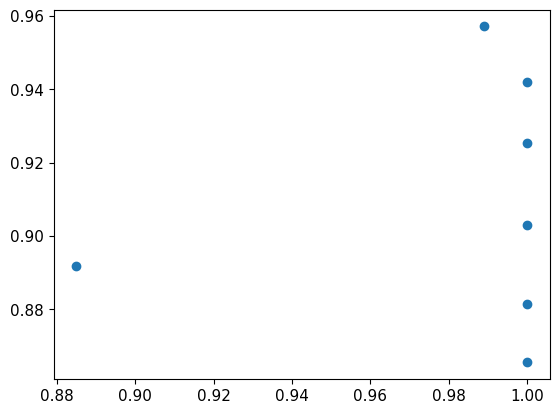

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

ps = []
rs = []
for k in prec_recall_curve:
    p, r = prec_recall_curve[k]
    ps.append(p)
    rs.append(r)

plt.figure()
plt.scatter(rs,ps)
plt.show()